- Name: Cody Smith
- PID: A11983710
- COGS118C - Assignment 3

# This notebook has [50 + 5 Bonus] points in total 
##### The number of points for each question is denoted by []. Make sure you've answered all the questions and that the point total add up.

# Lab 3 - Time-Frequency Analysis and Filtering

In this lab, we will cover time-frequency (TF) analysis, and the two main ways of doing this (short-time Fourier transform (STFT) and filtering). In particular, we will motivate why TF analysis is performed, rather than just applying Fourier Transform to your whole recording once. We will code for ourselves the operations required to perform STFT and filtering, then explore parameter choice considerations when applying these methods. From the time-frequency representation, we will compute the spectrogram, power spectral density, and phase coherence. We will also explore the effect of windowing on your spectral estimates. Finally, there is a practical tutorial on filtering and visualizing the frequency response of filters.

Key concepts:

- Short Time Fourier Transform (STFT)
- (Symmetry and orthogonality of DFT complex exponentials)
- Time-frequency uncertainty principle
- Power spectral density (PSD), event-related spectral response (ERSP) and phase coherence
- Windowing
- Convolution and filtering
- Filter parameter choices

**Note: in this lab, the written responses are entered in the cell immediately below the question, so that when you write your response, it doesn't screw up the formatting of the question. Thank you for this suggestion.** 

In [1]:
# make the imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal # we will also import the signal module, from scipy

In [2]:
def plot_spectrogram(spg, t, f, freq_lims=[0,100], plot_db=False):
    """
    Utility function for plotting the spectrogram for you.
    
    spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
    t: time axis of spectrogram
    f: frequency axis of spectrogram
    freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
    """
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

# Time and Frequency Resolution
At the heart of time-frequency analysis is the ability to resolve how frequencies change over time, whereas a single Fourier transform (or power spectrum) is unable to. Below, we will simulate a 20-second signal to analyze. I plot the data in time for you already.

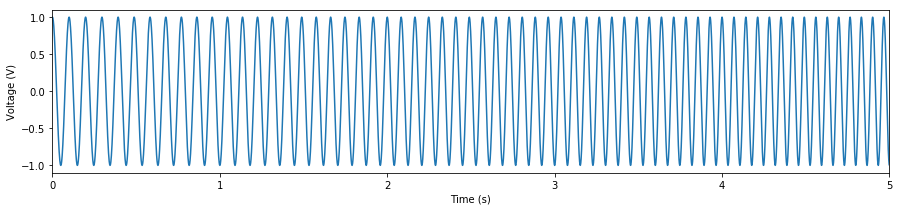

In [3]:
T, fs = 20, 1000
t = np.arange(0,T,1/fs)
# simulate a signal
# refer to the function documentation for f0, t1, f1
sig = signal.chirp(t, f0=10, t1=20,f1=30)

# plot it
plt.figure(figsize=(15,3))
plt.plot(t,sig)
plt.xlim([0,5])
plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');

# [5] Q1: Computing Power Spectrum
[3] 1.1: Compute the power spectrum of the signal (store in variable `ps`), starting from its Fourier transform (`np.fft.fft`). Plot the power spectrum and label your axes. **Remember, plot x-axis as frequency in Hz, this is now an implicit requirement moving forward for all frequency domain plots unless otherwise stated.** You can use `np.fft.fftfreq`). Zoom into 0-50Hz.

[1] 1.2: Comment on the frequency content of the signal based on the power spectrum (i.e., what frequencies are present and/or domninant).

[1] 1.3: Does what you see in the time-seres plot (above) match what you see in the power spectrum, in terms of frequency content? Feel free to manipulate the x-limits of the time series plot to explore.

**Response for 1.2:** My frequencies between 10 and 30 are dominant

**Response for 1.3:** The time series plot seems to match at around the 12 Hz range.


(0, 50)

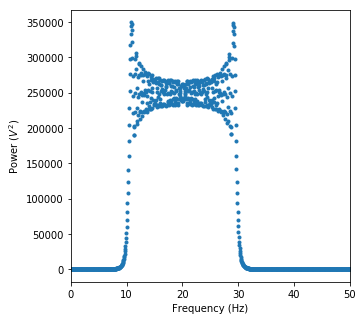

In [4]:
dt = 1/fs

ps = (np.abs(np.fft.fft(sig)))**2
freqs = np.fft.fftfreq(len(sig),dt)
plt.figure(figsize=(5,5))
plt.plot(freqs, ps, '.')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power ($V^2$)")
plt.xlim(0,50)

# [5] Q1 - Continued
[1] 1.4: You'll be doing this a lot in the following section, so create a function that computes the power spectrum (`pwsp`) given a signal and it's sampling frequency, as well as returning the frequency axis (`freqs`).

[1] 1.5: Using your function, compute the power spectrum of the **first second** of the signal, i.e., where t=[0,1) (this notation means inclusive of t=0, and exclusive of t=1, i.e. t>=0 and t\<1.). Hint: this is the first 1000 points of the signal, since `fs=1000`. Plot the power spectrum and zoom into 0-50Hz (you'll be doing this a lot too, so consider making an addition functional for plotting, though this is not required).

[1] 1.6: Repeat 1.5, but for the last second of the data. You can plot them on the same plot. **Remember to label your traces as well using `plt.legend()`.**

[2] 1.7 Comment on the similarities and differences between the two power spectrum plotted for 1.5 and 1.6, and your interpretation of this in terms of the frequency content. Compare this plot with the plot for Question 1.1, what are their similarities and differences?

**Response for 1.7:** The way in which they are similar is that they both seem to peak at around a power of 100000 $V^2$ but they differ in that my first power spectrum seems to peak higher than my second and so I am just going to assume that the signals frequency will decrease over time. The way that they compare similar to the previous graph from Q 1.1 is that the First seems to peak higher than the last. 

(0, 50)

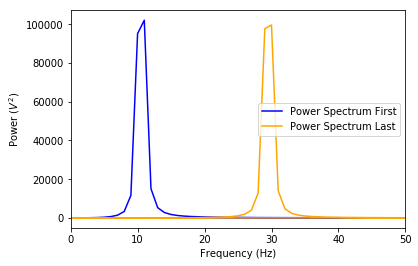

In [5]:
def compute_pwsp(sig, fs):
    freqs = np.fft.fftfreq(len(sig),1/fs)
    pwsp = np.abs(np.fft.fft(sig))**2
    return pwsp, freqs
    
pwsp_first, freqs_win = compute_pwsp(sig[0:1000],fs) 
pwsp_last, _ = compute_pwsp(sig[-1000:], fs)

plt.figure(figsize=(6,4))
plt.plot(freqs_win, pwsp_first,label='Power Spectrum First', color='blue' )
plt.plot(freqs_win, pwsp_last, label='Power Spectrum Last' , color ='orange')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power ($V^2$)')
plt.legend()
plt.xlim(0,50)

# Symmetry and Nyquist Frequency in DFT
A quick note to explain it in code, see L9 slides for derivation.

(187.99436742034507+244.66949839282591j) (187.99436742034507-244.66949839282591j)
(0.9708572312884645-21.998168671646166j) (0.9708572312884645+21.998168671646166j)
(0.9999834335126273-3.113229835816977j) (0.9999834335126273+3.113229835816977j)


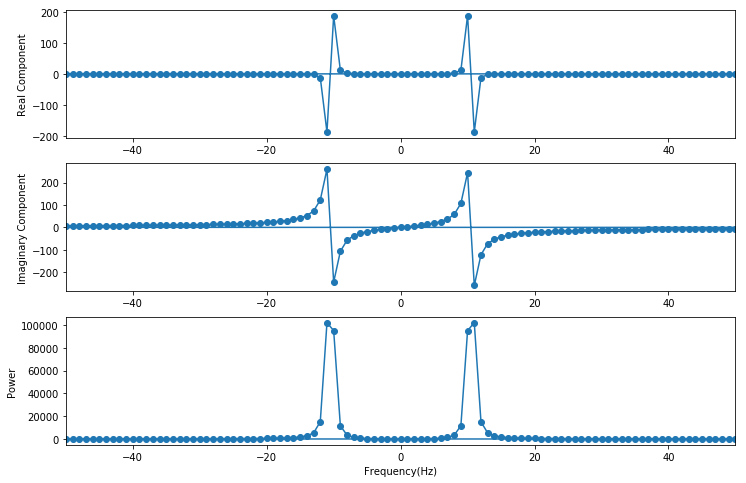

In [6]:
ft = np.fft.fft(sig[0:1000])
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(freqs_win, ft.real, '-o')
plt.xlim([-50,50]); plt.ylabel('Real Component')

plt.subplot(3,1,2)
plt.plot(freqs_win, ft.imag, '-o')
plt.xlim([-50,50]); plt.ylabel('Imaginary Component')

plt.subplot(3,1,3)
plt.plot(freqs_win, abs(ft)**2, '-o')
plt.xlim([-50,50]); 
plt.xlabel('Frequency(Hz)'); plt.ylabel('Power');

# print a few pairs just to see that it's true
print(ft[10], ft[-10])
print(ft[20], ft[-20])
print(ft[100], ft[-100])

---
If you recall, in A2, you were asked to compute the frequency in Hz from the wave numbers, k. There was a bonus question to make your frequencies match `np.fft.fftfreq()`, as that function returns negative frequencies after `fs/2`. `fs/2` is also known as Nyquist frequency, the fastest frequency you can resolve given a sampling rate of `fs` (not to be confused with Nyquist rate, which is the minimum sampling rate, 2B, required to accurately capture a signal with a maximum frequency of B).  

In addition, you were asked to plot the real and imaginary component of the Fourier Transform. I didn't make a comment on it then, but you may have noticed something a little funny, and again in the plots above as you plot the power spectra before zooming into 0 to 50Hz. In the cell above, I plot the real and imaginary components of the FT, and power spectrum you computed in Q1.1, zooming into -50 to 50Hz instead.

Notice that in the first plot (real component), the dots are symmetric about 0Hz, as if they are mirrored. The imaginary components (second plot), on the other hand, are anti-symmetric - mirrored but flipped about 0Hz. This means that for any frequency and its negative, their Fourier coefficients form a conjugate pair (symmetric about the real number line). As a byproduct, since the power is just the power squared magnitude of the vectors, it's also symmetric, while the phase (not plotted) are again anti-symmetric. This is a property of the DFT when applied to **real-valued signals**. We will go through the details in lecture, but for a formal proof, see [here](https://dsp.stackexchange.com/questions/8715/symmetry-of-real-and-imaginary-parts-in-fft). 

**Practically**, what this means is that half of the Fourier transform for a real-valued signal (the only kind you will work with in this class) is redundant. We can simply reconstruct the negative half from the positive half by inverting the imaginary component (or phase). **This will become relevant in Q3, where I return for you only the positive halves of the Fourier coefficents, up to `fs/2`, as that's the last (fastest) positive frequency represented.**

![](./img/complex_conjugates.png)
In the diagram above, the complex vectors **x** and **x\*** represent the complex coefficients at one frequency and its negative, while **y** and **y\*** are another pair of frequencies. Diagram from [here](https://betterexplained.com/articles/intuitive-arithmetic-with-complex-numbers/).

---
# Time-Varying Frequencies
Okay, back on track. Q1 should have demonstrated to you that simply taking a power spectrum is not sufficient for some signals. In particular, when a signal violates stationarity, it may have frequency content that changes over time. This is **important**, as most signals in nature are NOT stationary. It would be like taking an average of all the frames in a movie to see what the movie is about.

How do we overcome this? Using **Short Time Fourier Transforms (STFT)**. The principle behind this method is already demonstrated in the last part of Q1. Instead of taking one big Fourier transform across time, STFT takes snippets of the signal to measure its frequency content over time, giving us both frequency and time resolution (hence the name, time-frequency analysis). 

Instead of picking two arbitrary time windows, however, STFT does this more systematically. Specifically, it's parameterized by two additional parameters: window length (`len_win`), which corresponds to the length of the small window of data you want to compute over, and step length (`len_step`), which corresponds to how much you step forward to compute the FT of the next window. In the diagram below, `len_win`=M, and `len_step`=R. 

Instead of step length, some implementations use the parameter overlap length (`len_overlap`), which is how much the next window overlaps with the current one (L in diagram). This is simply the complement of R, i.e., L = M-R. This is what `scipy.signal.stft()` uses, so we will adopt that as well to minimize confusion.

![](./img/stft.png) (Image from [MATLAB](https://www.mathworks.com/help/signal/ref/stft.html))

---
Below, we will walk through the steps of constructing the STFT yourself. I will first ask you some math questions to consolidate the concept, then guide you through implementing the operation in code.

# [8] Q2: Step By Step
There's really nothing fancy about the STFT: forget about the Fourier transform part for a second. The fundamental component (and difference to the regular FT) is the stepping operation, taking a window (or chunk) of your data at regularly sized intervals - that's all! This operation is exactly analogous to what you did in A1 to find trial indices for ERPs, except at a regular interval. However, instead of acquiring the time indices from the experiment itself, you will compute them based on the parameters of the STFT.

[1] 2.1: In Q1.5, we took a 1-second window of data, which is 1000-points (since `fs=1000`Hz). If we were to compute the STFT, how many windows would the entire signal be divided into with no overlap? (Remember, `T=20` seconds)

[1] 2.2: What would be the timestamp (in seconds) of the zeroth data point in the 10th, 11th. and 12th window? 

[1] 2.3: What would be the corresponding array indices (in terms of the full data array) of those points from Q2.2? What is the formula you used to compute this?

[1] 2.4: If now we want to overlap each window by 0.5 seconds (500 data points), how many **full** windows would we end up with? What would be the time index of the zeroth data point in the 10th, 11th, and 12th window then?

[1] 2.5: What would be the array index (in terms of the full data array) of those points in Q2.4?

**Response for 2.1:** There will be 20 Windows

**Response for 2.2:** 10th: 10s, 11th: 11s, 12th: 12s

**Response for 2.3:** The formula that I used to find this answer was fs * window numbers

**Response for 2.4:** 10th = 4.5s , 11th = 5.0s , 12th = 5.5s

**Response for 2.5:** 10th = 4500 , 11th = 5000 , 12th = 5500
 

---
[1] 2.6: Complete the function `slide_window_time()` below, which returns an array that contains the zeroth timestamp of every window. E.g., if `len_win=1s` and `len_win=0.5s`, the first 3 elements of the array should be [0., 0.5, 1.0 ...]. Note that the last timestamp should be the start of a valid (full) data window, i.e., it has to be at least `len_win` less than the total signal time, `T`. Hint: one easy way to do this is to call `np.numpy()`, and throw out all the times values that cross into the last window.

[1] 2.7: Complete the function `slide_window_index()` below, which returns an array (of integers) that contains index of the zeroth data point of each window. E.g., if `len_win=1s` and `len_win=0.5s`, the first 3 elements of the array should be [0, 500, 1000 ...]. Note that it requires an additional argument, `fs`. Again, you can do this by stepping through as you do in 2.6, or just use the output of `slide_window_time()`.

[1] 2.8: Use the above two functions to confirm your response for Q2.2-2.5. `t_stft` should store the array of timestamps, while `ind_stft`, indices.

In [7]:
def slide_window_time(T,len_win,len_overlap):
    # T is total signal time, len_win is window length in seconds, len_overlap is overlap length in seconds
    t_steps = np.arange(0,T, len_win - len_overlap) #Creates a range from 0 to total time T, subtract for steps in between
    while t_steps[-1] + len_win > T:
        t_steps = t_steps[:-1]
    return t_steps
    
def slide_window_index(T,fs,len_win,len_overlap):
    t_steps = slide_window_time(T,len_win,len_overlap) * fs
    if(t_steps[-1]/fs) + len_win > T:
        t_steps = t_steps[:-1]
    return (t_steps+0.01).astype(int)  # change from float to save as an int   
    
# Q2.2-3
len_win = 1 # seconds
len_overlap = 0 # seconds
t_stft = slide_window_time(T, len_win, len_overlap)
ind_stft = slide_window_index(T, fs, len_win, len_overlap)
print(len(t_stft)) # print the number of windows
print(ind_stft[9:12]) #  print the zeroth timestamps and corresponding indices of windows 10-12

# Q2.4-5
len_win = 1 # seconds
len_overlap = 0.5 # seconds
t_stft = slide_window_time(T, len_win, len_overlap)
ind_stft = slide_window_index(T, fs, len_win, len_overlap)
print(len(t_stft)) # print the number of windows
print(ind_stft[9:12]) #  print the zeroth timestamps and corresponding indices of windows 10-12

20
[ 9000 10000 11000]
39
[4500 5000 5500]


# [2] Q3: Short-Time Fourier Transform
At this point, you have an array of data indices in `ind_stft`, which represents the index of the first data point of every window. The next step is very similar to what you did for computing an ERP: grab a window of data around those indices. Only it's even simpler here: you don't grab any data before that index, since it's the start of the window, and you grab `len_win` seconds worth of data following. 

[1] 3.1: Using array indexing and the values stored in `ind_stft` from Q2.5 (`len_win=1` & `len_overlap=0.5`), grab the last data window, which should be `win_len` long. Store that in the variable `data_win`. Do the same for the time indices (from `t`), and store it in `t_win`. Plot that window of data against its time indices. (Hint: it should start at t=19.)

[1] 3.2: Compute it's FT using `numpy.fft.fft()`, and plot the power spectrum. It should look the same as your (orange) trace from Q1.6.

(0, 50)

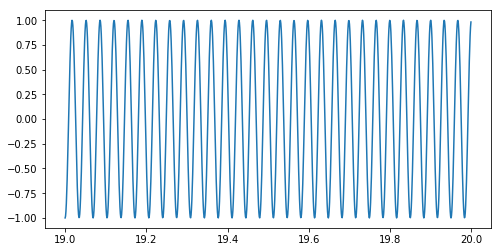

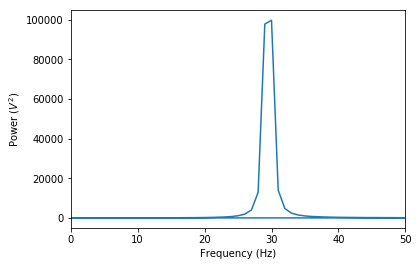

In [8]:
# grab a window of the signal and the corresponding time vector
sig_win = sig[int(ind_stft[-1]):len(sig)]
t_win = t[int(ind_stft[-1]):len(sig)]

# plot time series window
plt.figure(figsize=(8,4))
plt.plot(t_win,sig_win)

# compute power spectrum
pwsp , freqs = compute_pwsp(sig_win, fs)

# plot power spectrum
plt.figure(figsize=(6,4))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power ($V^2$)')
plt.plot(freqs, pwsp)
plt.xlim([0,50])

# [6] Q3 - Continued
[3] 3.3: The last two steps guides you on how to grab a single time window given it's starting index and compute the Fourier transform (and power spectrum). Complete the function `my_stft()` below, which should iterate over all window-start indices and grab the corresponding window of data and compute each Fourier Transform. Use the functions you've built previously. 

You need to return 3 output arguments: `f_stft`, the corresponding frequency axis for the STFT; `t_stft`, the time stamps for the zeroth data point of each window; and `stft`, the short time Fourier transform (2D matrix). `stft` should have shape (`len(f_stft), len(t_stft)`). Note here `f_stft` and `stft` should contain only the positive frequencies (I actually do that for you in the function, assuming you computed the variables correctly).

You can either loop through the time series and compute the Fourier transform of each window and store that in a matrix, or collect all the time series data in one go, and call `np.fft.fft()` once - it will perform a 1-dimensional FFT along the axis specified.

[1] 3.4: Compute the spectrogram from the STFT, which is the squared magnitude of every value in STFT. Store that in `spg`.

[1] 3.5: Plot the spectrogram you have computed using the helper function `plot_spectrogram()`. Set `freq_lims` to [0,50] Hz. I plot the spectrogram generated using `signal.spectrogram` for you, they should look identical. 

[1] 3.6: Comment on the spectrogram and what you can interpret from it about the signal.

[2] 3.7: Compute the power spectral density (PSD) from your spectrogram `spg`, as well as scipy's spectrogram `spg_sp` and plot them. They should look identical. Remember to label the traces and the axes appropriately. Note: don't worry about the normalization for spectral density for now, just take the average over time.

**Response for 3.6:** The spectrogram has delvelops a straight line that increases and around the time of 0.5 seconds it moves to the next window, so on and so forth. 

In [9]:
def my_stft(data, fs, len_win, len_overlap):
    T = len(data) * (1/fs)
    inds_stft = slide_window_index(T,fs,len_win,len_overlap) # We use our function to obtain 0th indicies
    t_stft = slide_window_time(T,len_win,len_overlap) # Calculating time at each 0th index
    f_stft = np.fft.fftfreq(int(len_win*fs), 1/fs) # This will find our range of frequencies
    stft = []
   
    #Let's create a for loop that will iterate and find the Fourier Transformation for each window
    #print(type(inds_stft)) Used this to help me debug
    
    for i in (inds_stft):
        i_win = [] # We will use this to store our stft calculations
        i_win = data[int(i) : int(i + ( len_win * fs))] # This will store our windows values to the appropriate place
        summ_stft = np.fft.fft(i_win) # Calculation of every stft
        stft.append(np.array(summ_stft))
   
    stft = (np.array(stft)).T # Nearly forgot to transpose this into the proper dimensions
    
    # clip the frequency axis to return just the non-negative frequencies
    # np.fft.fftfreq returns the nyquist frequency as negative, which we also need to keep
    positive_fs = np.logical_or(f_stft>=0, f_stft==-fs/2)    
    
    # I return for you just the positive frequencies 
    return abs(f_stft[positive_fs]), t_stft, stft[positive_fs, :]
    # clip the frequency axis to return just the non-negative frequencies
    # np.fft.fftfreq returns the nyquist frequency as negative, which we also need to keep
    positive_fs = np.logical_or(f_stft>=0, f_stft==-fs/2)    
    
    # I return for you just the positive frequencies 
    return abs(f_stft[positive_fs]), t_stft, stft[positive_fs, :]

<class 'numpy.ndarray'>
501 39 (501, 39)


Text(0.5,1,'scipy Power Spectrum Density')

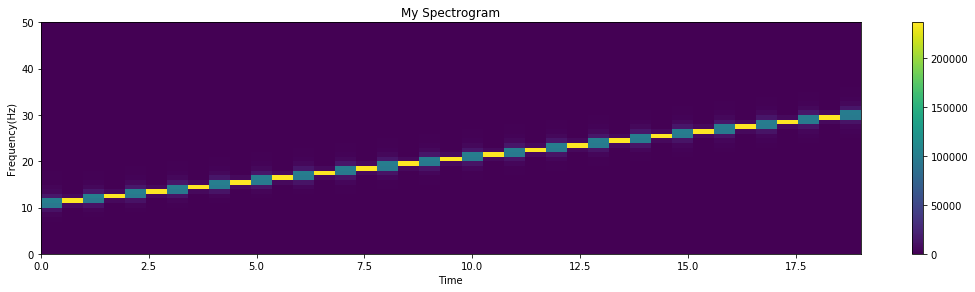

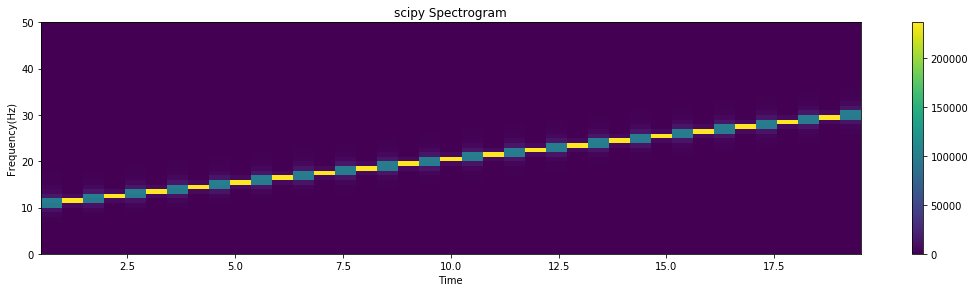

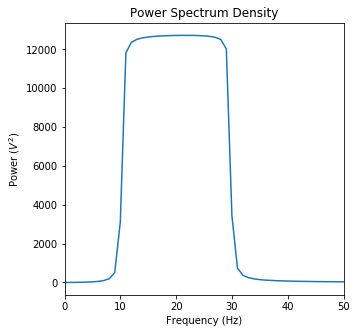

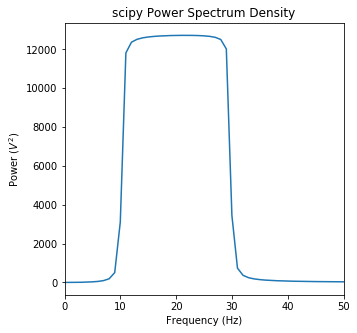

In [10]:
len_win = 1.
len_overlap = 0.5

# computing and plotting your spectrogram
f_stft, t_stft, stft = my_stft(sig , fs, len_win, len_overlap)
print(len(f_stft), len(t_stft), stft.shape) # print the shape of the STFT to confirm it is the right dimensions
spg = np.abs(stft)**2
plot_spectrogram(spg, t_stft, f_stft, freq_lims=[0,50], plot_db=False)
plt.title('My Spectrogram')

# I compute the spectrogram using scipy and plot it for you
f_sp, t_sp, spg_sp = signal.spectrogram(sig, fs, window='rect', nperseg=int(fs*len_win), noverlap=int(fs*len_overlap), detrend=False)
# I undo scipy's normalization for you so they will look the same
spg_sp = spg_sp*fs**2*len_win/2
plot_spectrogram(spg_sp, t_sp, f_sp, freq_lims=[0,50], plot_db=False)
plt.title('scipy Spectrogram');


# Power Spectrum Density calculated over all time given
density = np.mean(spg , axis=1)
scipy_density = np.mean(spg_sp, axis=1)


# computing and plotting your PSDs
plt.figure(figsize=(5,5))
plt.plot(f_stft,density)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power ($V^2$)')
plt.xlim([0,50])
plt.title('Power Spectrum Density')


plt.figure(figsize=(5,5))
plt.plot(f_stft,scipy_density)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power ($V^2$)')
plt.xlim([0,50])
plt.title("scipy Power Spectrum Density")


---
# Now let's try it on some real brain signals
We'll be working with the same LFP data as last time, recorded in the rat hippocampus. This dataset comes from an openly accessible neuroscience database. For more information on this particular dataset, see [here](https://crcns.org/data-sets/hc/hc-2/about-hc-2). 

We will use a slightly longer snippet of data to start (`lfp_short`, 2min), for the purpose of demonstrating the spectrogram.

dict_keys(['__header__', '__version__', '__globals__', 'lfp', 'fs', 'spike_indices', 'spike_fs'])
Sampling rate = 1250Hz


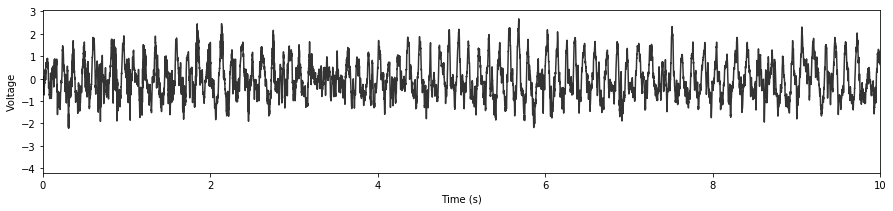

In [11]:
data = io.loadmat('./data/LFP.mat', squeeze_me=True)
print(data.keys())


# unpack the variables
fs = data['fs'] # sampling rate 
print('Sampling rate = %iHz'%fs)

lfp = data['lfp'][0,:]/1000 # this file contains two channels, we'll only work with the first one
lfp_short = lfp[:int(120*fs)] # make a variable that has only the first two seconds of the LFP
t_short = np.arange(0, len(lfp_short)/fs, 1/fs) # create the corresponding time vector

plt.figure(figsize=(15,3))
plt.plot(t_short,lfp_short, 'k', alpha=0.8)
plt.xlim([0,10])
plt.xlabel('Time (s)');plt.ylabel('Voltage');

# [6 + 2 Bonus] Q4: Applying STFT & PSD
[3] 4.1: **Using a window length of 1s, and overlap of 0.8s**, compute the STFT (using `my_stft`), spectrogram (**normalized/spectral density**), and PSD. Plot the spectrogram and PSD. I compute the PSD using sp.signal for you in `f_welch` and `p_welch`. Plot that to confirm you have the right answer (the PSDs should overlap). Zoom into 0 to 20Hz for both the spectrogram and PSD.

[1] 4.2: Repeat the above analyses and plots in a new cell, but **using a window length of 5s, and overlap of 4s**. You can literally copy and paste the entire block of code, changing just the variable values for `len_win` and `len_overlap`.

[2] 4.3: Discuss similarities and differences for two spectrograms, especially with respect to temporal and frequency resolution. Also compare the two sets of PSDs, noting the frequency content of the signal represented in both cases.

[BONUS: 2] 4.4: There is a known cause for the change in frequency for this neural oscillation in rats. What is the name of this oscillation, and what is the cause for the frequency change? Reference your source here.

**Response for 4.3:** What I found silimar between both signals was they were both close to finding the ture signal, but only one was close enough to it.

**Response for 4.4:** Theta Waves (~ 6 - 10Hz). Sleep, State of being Awake and Walking can change this frequency. https://en.wikipedia.org/wiki/Theta_wave (Is wikipedia even a credible source?)

<class 'numpy.ndarray'>


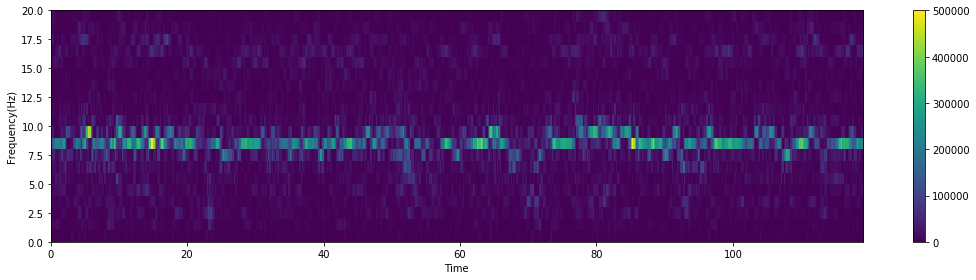

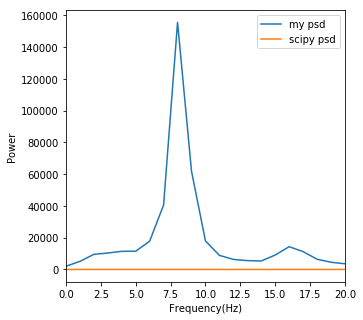

In [17]:
len_win = 1
len_overlap = 0.8

f_stft, t_stft, stft = my_stft(lfp_short, fs, len_win, len_overlap)
spg = np.abs(stft)**2
psd = np.mean(spg, axis=1)

# use plot_spectrogram
plot_spectrogram(spg, t_stft, f_stft, plot_db=False, freq_lims=[0,20])

# computing welch's spectrogram for you
f_welch, p_welch = signal.welch(lfp_short,fs,window='boxcar',nperseg=int(fs*len_win),noverlap=int(fs*len_overlap))
p_welch *= 0.5*len_win # again, undoing scipy's normalization

# plot the PSDs
plt.figure(figsize=(5,5))
plt.plot(f_stft,psd,label="my psd")
plt.plot(f_stft,p_welch,label="scipy psd")
plt.xlabel('Frequency(Hz)'); plt.ylabel('Power');
plt.xlim([0,20])
plt.legend()

<class 'numpy.ndarray'>


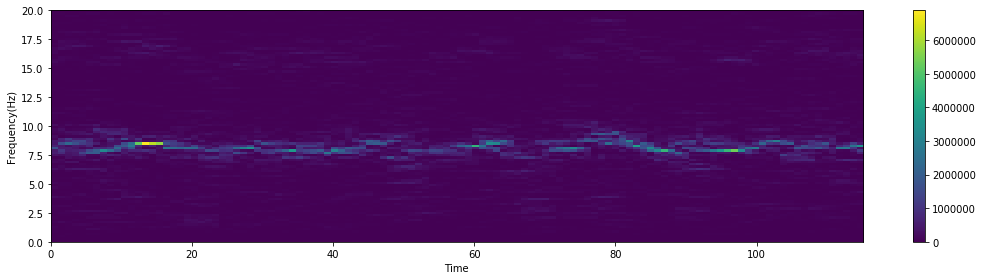

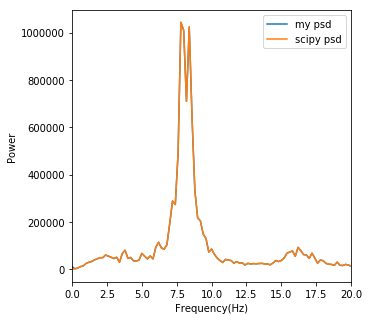

In [18]:
# 4.2 basically copy and paste from previous cell but change values for new window length of 5s and overlap of 4s 

len_win = 5.
len_overlap = 4.
f_stft, t_stft, stft = my_stft(lfp_short,fs,len_win,len_overlap)  
spg = np.abs(stft)**2
psd = np.mean(spg,axis=1)

# use plot_spectrogram
plot_spectrogram(spg, t_stft, f_stft, plot_db=False, freq_lims=[0,20])
plt.ylim([0,20])

# computing welch's spectrogram for you
f_welch, p_welch = signal.welch(lfp_short,fs,window='boxcar',nperseg=int(fs*len_win),noverlap=int(fs*len_overlap))
p_welch = p_welch*fs**2*len_win/2 # again, undoing scipy's normalization

# plot the PSDs
plt.figure(figsize=(5,5))
plt.plot(f_stft,psd,label="my psd")
plt.plot(f_stft,p_welch,label="scipy psd")
plt.xlabel('Frequency(Hz)'); plt.ylabel('Power');
plt.xlim([0,20])
plt.legend()

# Intermission & scipy.signal
Q4 is an example of what practical (neural) signal processing is about: making informed parameter decisions based on your data and the question you want to answer. We've covered most of the math details already, so from this point on, the labs will shift focus from implementing the analysis toolkits to applying them and making sound judgements for your analysis parameters.

---
In the exercises above, I call functions from the `scipy.signal` module to check your answers for you, which has most of the functions relevant for digital signal processing, especially for this class. As we progress through more complex material, you will be asked to use them directly to speed things up, and certainly for your final project, so it's important to be familiar with the documentation for them. To view documentation, put your cursor inside the brackets of the function call in a code cell, and press shift+tab+tab.

In particular, the following functions are relevant for you for this lab:
- `signal.stft()`: computing STFT
- `signal.welch()`: computing PSD using STFT with optional overlapping windows
- `signal.windows`: a sub-module that contains windowing functions
- `signal.firwin()`: computing FIR filter coefficients
- `signal.hilbert()`: computing the Hilbert transform

Note: most of the functions above take in the **number of points** as it's length arguments, such as `nperseg` (number of data points per window) and `noverlap`. We still want to define our length parameters in units of seconds because that's more intuitive, so take note to convert them to number of points (and they have to be integers) by multiplying by the sampling rate.

---
# [6] Q5: Windowing & PSD
This question illustrates how windowing with different window functions can give rise to slightly different spectral estimates. As a reminder, windowing is multiplying your short-time data segments with a windowing function, and is done regardless whether you perform it explicitly (in that case, a "boxcar" window is equivalently used). This is equivalent to convolving the "true" signal power spectrum with the spectral profile of the window.

[1] 5.1: Since all the `scipy.signal` functions specify window length in terms of points, complete the function `secs_to_points` that converts the length variables in time (`len_win`, `len_overlap`) to number of points. Remember to return `ints`. We will still specify parameters in units of second, but convert them to points before using for `scipy` calls from this point on.

[1] 5.2: With window length of 2s and overlap length of 1s, compute the PSD using `signal.spectrogram()` by averaging the spectrogram, as well as using `signal.welch()`, specifying `fs`, `nperseg`, and `noverlap` from above. Plot the two PSDs and zoom into 0-30Hz. They should **not look identical**, and I print the percentage difference at the maximum point for you, it should be around 3.49%.

[1] 5.3: Find the default windows used `signal.welch()` and `signal.spectrogram()`. Create them both using `signal.windows`, where `n=nperseg`, and plot them.

[1] 5.4: Estimate their spectral response by simply taking the squared magnitude of their Fourier Transform. Plot them in frequency domain and zoom into [-5, 5] Hz. Remember to label the traces and the axes for this and the above plots!

[2] 5.5: Describe the differences between the two spectral responses. In particular, note the height of the center point, and the main lobe. Is this consistent with the differences in the PSD estimates from Q5.2? Why or why not? Hint: convolution.

**Response for 5.5:**

No handles with labels found to put in legend.


0.0


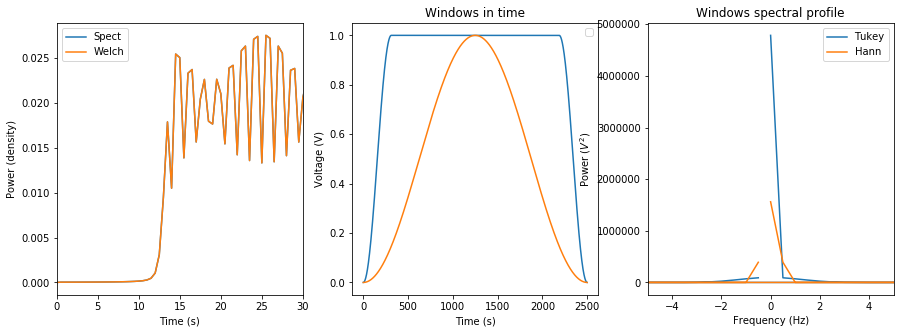

In [30]:
def secs_to_points(fs, len_win, len_overlap):
    nperseg = int(len_win*fs)
    noverlap = int(len_overlap*fs)
    return nperseg, noverlap

nperseg, noverlap = secs_to_points(fs, len_win=2, len_overlap=1)

f_spg, t_spg, spg = signal.spectrogram(sig,fs,window='rect',nperseg=nperseg,noverlap=noverlap) #I looked at the documentation 
p_spg = np.mean(spg,axis=1) #for computing your PSD
f_welch, p_welch = signal.welch(sig,fs,window='box',nperseg=nperseg,noverlap=noverlap)
print(100*(p_spg[16]-p_welch[16])/p_welch[16])

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
#for plotting PSDs
plt.plot(f_spg,p_spg, label= 'Spect')
plt.plot(f_spg,p_welch, label= 'Welch')
plt.xlabel('Time (s)')
plt.ylabel('Power (density)')
plt.legend()
plt.xlim([0,30])

win_tukey = signal.get_window(("tukey",0.25), nperseg) #We will use the built in function to grab our window for tukey
win_hann = signal.get_window("hann", nperseg) #We will use the built in function to grab our window for hann

plt.subplot(1,3,2)
#for plotting windows
plt.plot(range(0,2500),win_tukey)
plt.plot(range(0,2500),win_hann)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend(); plt.title('Windows in time')

plt.subplot(1,3,3)
#for plotting windows in frequency
wins_spectral_t = np.abs(np.fft.fft(win_tukey))**2 #find power of tukey
wins_spectral_h = np.abs(np.fft.fft(win_hann))**2 #find power of hann
freqs_range = np.fft.fftfreq(len(win_tukey),1/fs) #We will use this to find the frequency range  
plt.plot(freqs,wins_spectral_t,label='Tukey')
plt.plot(freqs,wins_spectral_h,label='Hann')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power ($V^2$)')
plt.xlim([-5,5])
plt.legend(); plt.title('Windows spectral profile');

# [8 + 2 Bonus] Q6: Coherence
Now we will look at inter-trial coherence: in this experiment, the rat is freely running around. At some points, there will be events that prompts it to do something, or be given a reward, similar to the stimulus in the ERP experiment. I have given you the time points of those events in `t_trials`. We will look at how stimulus in those trials affect the strong rhythm we saw in the PSD, at 8.5Hz.

[1] 6.1: Compute the STFT using `signal.stft`, using a 'hann' window.

[1] 6.2: We will be looking at the coherence of the dominant oscillation, which is about 8.5Hz. Find the index of the frequency vector where it equals to 8.5Hz. Equivalently, compute the wave number k for the 8.5Hz oscillation.
8.5Hz.

[1] 6.3: To start, we will look at the coherence of 7 random trials. This is often done to establish a null for what to expect by chance. You will notice that the individual complex vectors (dashed) have different lengths. To compute coherence, which we will define to be the magnitude (length) of the averege complex vector, we want to remove the effect of individual trial powers. In the for loop, add a line to normalize the complex coefficient of each trial, `X_trial`, by its length. Do the same for the average, `X_mean`.

[1] 6.4: Compute and print the coherence value. Again, we define that here as the magnitude of the average **length-normalized** vector. This should be around 0.1765.

[1] 6.5: Repeat the analyses for the real trials, given the trial times `t_trials`. This is similar to what you did for the ERP analysis. To make your life easier, these trial times can be matched exactly to the STFT window times. Your first task is to find the STFT indices (in the time dimension) that correspond to these trial times. Store that in `trial_inds`.

[2] 6.6: Repeat the plotting and coherence computation in Q7.3-4, but using the trial indices you just found. Plot these in the same figure, but in red. (Just change the `k` in `'k.--'` to `r`). Don't forget the normalization. The single trial vectors should be cluster around pi/2, and the coherence value should be very high (0.988).

[BONUS: 2] 6.7: Repeat 6.5-6, but for the STFT window immediately before the onset of the trial. This should allow you to compute the *change* in coherence.

[1] 6.8: What is your interpretation of this result, in the context of the experiment? i.e., how does the stimulus affect the oscillation, compared to the randomly chosen time windows?

**Response for 6.8:** ANSWER

In [ ]:
# Trial times
t_trials = np.array([6., 22., 45., 63., 78., 111., 118.])

# Use these length settings for STFT
nperseg, noverlap = secs_to_points(fs, len_win=2, len_overlap=1)

# compute stft
f_stft, t_stft, stft = #_YOUR_CODE_HERE

# find the index (k) of 8.5Hz.
f_ind = #_YOUR_CODE_HERE


# grab random slices of the STFT to compute coherence 
np.random.seed(0)
trial_inds = np.random.randint(0,len(t_stft), size=len(t_trials))

plt.figure(figsize=(5,5))
plt.xlabel('Real'); plt.ylabel('Imag')
# plot all trial vectors
for trial_ind in trial_inds:
    X_trial = stft[f_ind, trial_ind].squeeze()
    
    # normalize by vector length
    #X_trial = #_YOUR_CODE_HERE
    
    plt.plot([0,X_trial.real], [0, X_trial.imag], 'k.--', alpha=0.5)
    
# plot mean vector
X_mean = #_YOUR_CODE_HERE
plt.plot([0,X_mean.real], [0, X_mean.imag], 'ko-', alpha=0.5)

coherence = #_YOUR_CODE_HERE
print(coherence)

# ---------- now do it for real -------------------
# get trial indices from trial times
trial_inds = #_YOUR_CODE_HERE

for trial_ind in trial_inds:
    #_YOUR_CODE_HERE

# FIR Filtering & Filter Response
There are 4 types of filters: lowpass, highpass, bandpass, and bandstop. They refer to the frequency response of the filter, e.g., lowpass means to allow low frequencies through (from 0Hz to the cutoff) and filter out high frequencies, the opposite for highpass. Bandpass allows through a narrow band frequency and filters out the rest, while bandstop does the opposite, which is commonly used for filtering out a specific frequency of noise (such as 60Hz line noise). Filter design is an art that will take many such labs to cover extensively, so we will just introduce the idea here and give you the tools to explore that at a later stage (such as for your project).

### Finite Impulse Response 
The filter response can be examined in both time and frequency domain. If we plot the coefficients of an FIR filter in time, that's quite literally its impulse response function, i.e., if you tried to filter a delta with this function, it will output itself. FIR stands for finite impulse response, which means the impulse response function has finite time. Infinite impulse response (IIR) filters, on the other hand, have feedback, and thus will continue out to infinity even for a single delta input. We will only be using FIR filters for this course.

---
### `signal.firwin()`
A quick tutorial on `signal.firwin()`: this function designs the FIR filter based on your frequency requirements, and return the filter coefficients. The 4 critical parameters are `numtaps`, `fs`, `cutoff`, and `pass_zero`. 

- `numtaps` is the filter "order", basically, how many points are in the filter. The longer the filter is, the better frequency resolution you will have, but worse temporal resolution.
- `fs` is the sampling rate of your signal
- `cutoff` defines the frequency to pass/block
- `pass_zero` defines whether 0Hz is passed or blocked

`cutoff` and `pass_zero`, in conjunction, defines the filter type. If your cutoff is at 20Hz and define `pass_zero=True`, then `firwin()` interprets that to be a lowpass filter. If `pass_zero=False`, then it's a highpass filter. Same idea applies to bandpass and bandstop, except `cutoff` is now required to be a tuple.

---
### `np.convolve()`
Finally, to apply the filter, we simply convolve the signal with the filter, using `np.convolve()`. Remember, convolution in time domain is multiplication in frequency domain, and actually, I believe `np.convolve()` is implemented via FFT and multiplication in the frequency domain.

Below, I will demonstrate an example of a lowpass filter, plotting its IRF in time and frequency.

Text(0,0.5,'Voltage (V)')

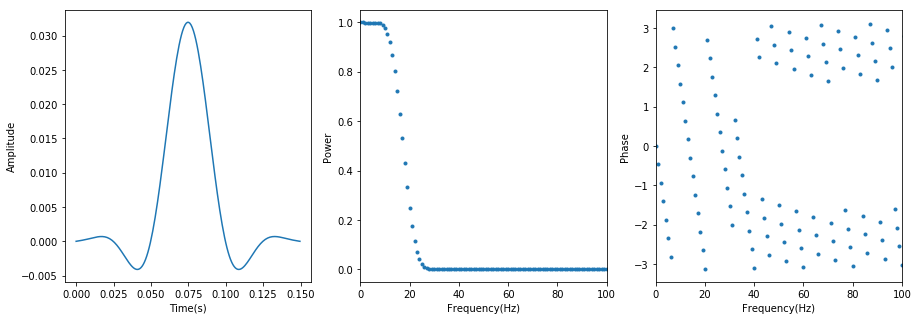

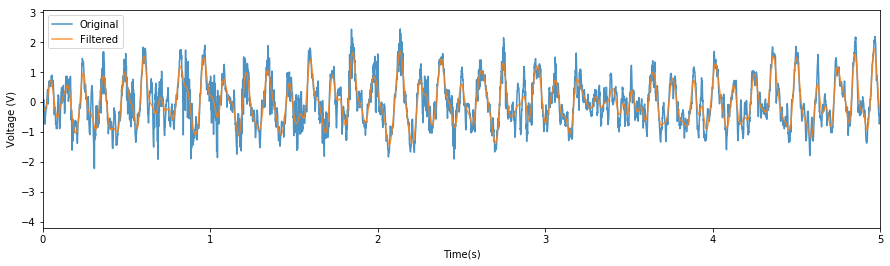

In [24]:
cutoff = 20 #Hz

# we typically want a filter order to be at least as long as 3 periods (cycles) of 
# the slowest frequency in the cutoff. 
# so if cutoff is 20Hz, we want 3*0.05s = 0.15s long, which is 0.15*fs points
# the larger this number is, the better frequency resolution you will have
filt_order = int(3*fs/cutoff)+1
filt_coefs = signal.firwin(filt_order, cutoff, fs=fs, pass_zero=True)

# compute the magnitude and phase response of the filter
freq_resp = np.fft.fft(filt_coefs, n=int(fs))
mag_resp = abs(freq_resp)**2
ph_resp = np.angle(freq_resp)
freqs = np.fft.fftfreq(int(fs),1/fs)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
# plot impulse response
t_filt = np.arange(0,len(filt_coefs))/fs
plt.plot(t_filt,filt_coefs)
plt.xlabel('Time(s)'); plt.ylabel('Amplitude'); 

plt.subplot(1,3,2)
plt.plot(freqs, mag_resp, '.')
plt.xlabel('Frequency(Hz)'); plt.ylabel('Power'); 
plt.xlim([0,100])

plt.subplot(1,3,3)
plt.plot(freqs, ph_resp, '.')
plt.xlabel('Frequency(Hz)'); plt.ylabel('Phase'); 
plt.xlim([0,100])

plt.figure(figsize=(15,4))
lfp_filt = np.convolve(lfp_short, filt_coefs, mode='same')
plt.plot(t_short, lfp_short, alpha=0.8, label='Original')
plt.plot(t_short, lfp_filt, alpha=0.8, label='Filtered')
plt.xlim([0,5])
plt.legend()
plt.xlabel('Time(s)');plt.ylabel('Voltage (V)')

# [4 + 1 Bonus] Q7: Filter Decisions
Following the template from above, do the following:
- construct filter coefficients using `signal.firwin()`
- plot the IRF in time and frequency domain (both magnitude and phase)
- filter the lfp signal using `np.convolve`, and plot both signals in time (zoom into first 5 seconds)
- plot the power spectrum of both the original and filtered signal. (I didn't do this for you)

[1] 7.1: a band-pass filter, with cut-off between 4-12Hz.

[1] 7.2: a band-stop filter, with cut-off between 4-12Hz.

[1] 7.3: a high-pass filter, with a cut-off at 0.1Hz.

[1] 7.4: Which of the above is most suitable for isolating (keeping) the dominant frequency in the LFP.

[BONUS 1] 7.5: since you will be doing the same sequence of operations above multiple times, it's useful to think about how to construct them into functions. You will be rewarded 2 bonus points if, after your function definition, each of the points above is completed in one line of code (to your function call). 

**Response for 7.4:** ANSWER

In [ ]:
# Code for 7.1-3. You can use more than one cell.
cutoff = ()
cutoff = ()
cutoff = ()


filt_coefs = signal.firwin(filt_order, cutoff, fs=fs, pass_zero=True)
filt_coefs = signal.firwin(filt_order, cutoff, fs=fs, pass_zero=False)
filt_coefs = signal.firwin(filt_order, cutoff, fs=fs, pass_zero=False)
filt_coefs = signal.firwin(filt_order, cutoff, fs=fs, pass_zero=False)


In [ ]:
# 7.2 Cut-off between 4 - 12 Hz

In [ ]:
# 7.3 Cut-off between 4 - 12 Hz

# Congratulations!
You have just performed your first time-frequency analysis on neural data! While Fourier analysis from the last lab is the basis of signal analysis (and of the methods today), the set of tools presented here are the ones practicing neuroscientists actually use on a daily basis, including computing PSD and coherence. In addition, filtering has broad applications across domains, especially in sound engineering. Almost every lab in Cognitive Science and Neuroscience that record electrophysiological data here at UCSD will employ these tools for their analysis, so understanding these well will certainly position you to become an effective research assistant, or even graduate student researcher.

# End Survery
Please take a few minutes to fill out the following as it will help us to improve the following assignments & lectures.

# Content:
What was one thing you learned from this lab & associated lectures?

ANSWER: I learned about the different types of filters that we can apply to noisy data.

---
What was one thing that you still found confusing after the lab, and need clarification?

ANSWER: I think that i'm just confused about what I can do in python with respect to coding signals.

# Style:
What was one thing you enjoyed about the formatting of this assignment (e.g., clarity, structure, guidance, etc.)?

ANSWER: I like that it got me to ask around how go about doing a PA like this. To be honest this was a pretty hard PA and I think I am still confused about what I am doing , but I appreciate the help I recieve from some of my classmates through Piazza.

---
What was one thing that you thought could use improvements on?

ANSWER: It could be a lot more clearn about what goes in to a function that we might want because I don't intitively think about setting a up a for or a while loop sometimes, but I think I should try to just get into the flow of doing so. 


# Thank you!